In [1]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None
        self.col = None
        self.col_W = None
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = (H + 2*self.pad - FH)//self.stride + 1
        out_w = (W + 2*self.pad - FW)//self.stride + 1

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis = 0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx



In [2]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True, flatten=False)
print('x_train :', np.shape(x_train))
print('t_train :', np.shape(t_train))
print('x_test :', np.shape(x_test))
print('t_test :', np.shape(t_test))

x_train : (60000, 1, 28, 28)
t_train : (60000, 10)
x_test : (10000, 1, 28, 28)
t_test : (10000, 10)


In [3]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)])
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:,:,y,x,:,:] = img[:,:,y:y_max:stride, x:x_max:stride]

    col = col.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w, -1)
    return col

In [4]:
import numpy as np
window_h = 3
window_w = 3

x1 = np.random.rand(1,3,4,4)
col1 = im2col(x1, window_h, window_w, stride=1, pad=0)
print('x1.shape :', x1.shape)
print('col1.shape :', col1.shape)
col1 = col1.reshape(-1, window_h*window_w)
print('col1 reshape 후 shape :', col1.shape)
print('')

x2 = np.random.rand(2, 1, 5, 5)
col2 = im2col(x2, window_h, window_w, stride=1, pad=0)
print('x2.shape :', x2.shape)
print('col2.shape :', col2.shape)
col2 = col2.reshape(-1, window_h*window_w)
print('col2 reshape 후 shape :', col2.shape)

x1.shape : (1, 3, 4, 4)
col1.shape : (4, 27)
col1 reshape 후 shape : (12, 9)

x2.shape : (2, 1, 5, 5)
col2.shape : (18, 9)
col2 reshape 후 shape : (18, 9)


In [5]:
pad = 3
array_2d = np.array([[1,2,3],
                    [4,5,6]])

print('패딩이 적용되 전 arrya_2d :', array_2d, sep="\n")
print('')

pad_array_2d = np.pad(array_2d, ((pad, pad), (pad, pad)))
print('3 패딩이 적용된 array_2d :', pad_array_2d, sep='\n')

패딩이 적용되 전 arrya_2d :
[[1 2 3]
 [4 5 6]]

3 패딩이 적용된 array_2d :
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 3 0 0 0]
 [0 0 0 4 5 6 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [6]:
pad = 2
bw_img_data = np.array([[[[1,2,3,0],
                         [0,1,2,3],
                         [3,0,1,2],
                         [2,3,0,1]]]])
print('데이터 :', bw_img_data, sep='\n')
print('데이터 shape :', bw_img_data.shape)

pad_bw_img_data = np.pad(bw_img_data, [(0,0), (0,0), (pad, pad), (pad, pad)])
print('')
print('2 패딩이 적용된 데이터 :', pad_bw_img_data, sep='\n')
print('2 패딩이 적용된 데이터 shape :', pad_bw_img_data.shape)

데이터 :
[[[[1 2 3 0]
   [0 1 2 3]
   [3 0 1 2]
   [2 3 0 1]]]]
데이터 shape : (1, 1, 4, 4)

2 패딩이 적용된 데이터 :
[[[[0 0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0 0]
   [0 0 1 2 3 0 0 0]
   [0 0 0 1 2 3 0 0]
   [0 0 3 0 1 2 0 0]
   [0 0 2 3 0 1 0 0]
   [0 0 0 0 0 0 0 0]
   [0 0 0 0 0 0 0 0]]]]
2 패딩이 적용된 데이터 shape : (1, 1, 8, 8)


In [7]:
pad = 1
img_data = np.random.rand(1,3,4,4)
print('정규화된 데이터 : ', img_data, sep='\n')
print('정규화도니 데이터 shape :', img_data.shape)

pad_img_data = np.pad(img_data, [(0,0), (0,0), (pad, pad), (pad, pad)])
print('')
print('1 패딩이 적용된 데이터 :', pad_img_data, sep='\n')
print('1 패딩이 적용된 데이터 shape :', pad_img_data.shape)

정규화된 데이터 : 
[[[[0.22075877 0.56074948 0.76635941 0.00811926]
   [0.12723597 0.67884778 0.89788413 0.99722833]
   [0.84979879 0.45185165 0.78277208 0.93799477]
   [0.10938518 0.02186101 0.43164242 0.18052619]]

  [[0.67360803 0.54969696 0.84229341 0.13816112]
   [0.25034876 0.21505377 0.16191027 0.9929289 ]
   [0.96298888 0.72784791 0.84981357 0.58571777]
   [0.48032153 0.1535079  0.1404452  0.01363936]]

  [[0.91847464 0.90492364 0.39777464 0.65505983]
   [0.43771171 0.44450704 0.35842762 0.41284031]
   [0.29664806 0.32111983 0.46286693 0.97702319]
   [0.32648675 0.43029845 0.95321842 0.31838858]]]]
정규화도니 데이터 shape : (1, 3, 4, 4)

1 패딩이 적용된 데이터 :
[[[[0.         0.         0.         0.         0.         0.        ]
   [0.         0.22075877 0.56074948 0.76635941 0.00811926 0.        ]
   [0.         0.12723597 0.67884778 0.89788413 0.99722833 0.        ]
   [0.         0.84979879 0.45185165 0.78277208 0.93799477 0.        ]
   [0.         0.10938518 0.02186101 0.43164242 0.18052619 0.

In [8]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = np.zeros((N,C,H + 2*pad + stride - 1, W + 2*pad + stride -1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:,:, y:y_max:stride, x:x_max:stride]+=col[:,:,y,x,:,:]

    return img[:, :, pad:H + pad, pad:W + pad]

In [9]:
class ReLU:
    def __init__(self):
        self.boolean_array = None
    def forward(self, x):
        self.boolean_array = (x <= 0)
        out = x.copy()
        out[self.boolean_array] = 0
        return out

    def backward(self, dout):
        dout[self.boolean_array] = 0
        dx = dout
        return dx

In [10]:
x = np.array([[1.0, -1.5],
             [-4.0, 6.0]])
boolean_array = (x<=0)
print(boolean_array)

[[False  True]
 [ True False]]


In [11]:
out = x.copy()
print('out :', out, sep='\n')

out :
[[ 1.  -1.5]
 [-4.   6. ]]


In [12]:
print('out[boolean_array]:', out[boolean_array])

out[boolean_array] = 0
print('out :', out, sep='\n')

out[boolean_array]: [-1.5 -4. ]
out :
[[1. 0.]
 [0. 6.]]


In [13]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N,C,H,W = x.shape
        out_h = (H - self.pool_h)//self.stride + 1
        out_w = (W - self.pool_w)//self.stride + 1

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0,2,3,1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [14]:
pool_h =2
pool_w = 2
stride = 2
pad = 0

x=np.arange(32)
x=x.reshape(2,1,4,4)

print('맨 처음 데이터 : ', x, sep='\n')
print('맨 처음 데이터 shape :', x.shape)
print('')

im2col_x = im2col(x, pool_h, pool_w, stride, pad)
print('im2col 적용 후 데이터 :', im2col_x, sep='\n')
print('im2col 적용 후 데이터 shape :', im2col_x.shape)

im2col_x = im2col_x.reshape(-1, pool_h*pool_w)
print('reshape 후 데이터 :', im2col_x, sep='\n')
print('')

print('reshape 후 데이터 shape :', im2col_x.shape)

맨 처음 데이터 : 
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]]


 [[[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]]]
맨 처음 데이터 shape : (2, 1, 4, 4)

im2col 적용 후 데이터 :
[[ 0.  1.  4.  5.]
 [ 2.  3.  6.  7.]
 [ 8.  9. 12. 13.]
 [10. 11. 14. 15.]
 [16. 17. 20. 21.]
 [18. 19. 22. 23.]
 [24. 25. 28. 29.]
 [26. 27. 30. 31.]]
im2col 적용 후 데이터 shape : (8, 4)
reshape 후 데이터 :
[[ 0.  1.  4.  5.]
 [ 2.  3.  6.  7.]
 [ 8.  9. 12. 13.]
 [10. 11. 14. 15.]
 [16. 17. 20. 21.]
 [18. 19. 22. 23.]
 [24. 25. 28. 29.]
 [26. 27. 30. 31.]]

reshape 후 데이터 shape : (8, 4)


In [15]:
pool_h =2
pool_w = 2
stride = 1
pad = 0

x=np.arange(27)
x=x.reshape(1,3,3,3)

print('맨 처음 데이터 : ', x, sep='\n')
print('맨 처음 데이터 shape :', x.shape)
print('')

im2col_x = im2col(x, pool_h, pool_w, stride, pad)
print('im2col 적용 후 데이터 :', im2col_x, sep='\n')
print('im2col 적용 후 데이터 shape :', im2col_x.shape)

im2col_x = im2col_x.reshape(-1, pool_h*pool_w)
print('reshape 후 데이터 :', im2col_x, sep='\n')
print('')

print('reshape 후 데이터 shape :', im2col_x.shape)

맨 처음 데이터 : 
[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]]

  [[ 9 10 11]
   [12 13 14]
   [15 16 17]]

  [[18 19 20]
   [21 22 23]
   [24 25 26]]]]
맨 처음 데이터 shape : (1, 3, 3, 3)

im2col 적용 후 데이터 :
[[ 0.  1.  3.  4.  9. 10. 12. 13. 18. 19. 21. 22.]
 [ 1.  2.  4.  5. 10. 11. 13. 14. 19. 20. 22. 23.]
 [ 3.  4.  6.  7. 12. 13. 15. 16. 21. 22. 24. 25.]
 [ 4.  5.  7.  8. 13. 14. 16. 17. 22. 23. 25. 26.]]
im2col 적용 후 데이터 shape : (4, 12)
reshape 후 데이터 :
[[ 0.  1.  3.  4.]
 [ 9. 10. 12. 13.]
 [18. 19. 21. 22.]
 [ 1.  2.  4.  5.]
 [10. 11. 13. 14.]
 [19. 20. 22. 23.]
 [ 3.  4.  6.  7.]
 [12. 13. 15. 16.]
 [21. 22. 24. 25.]
 [ 4.  5.  7.  8.]
 [13. 14. 16. 17.]
 [22. 23. 25. 26.]]

reshape 후 데이터 shape : (12, 4)


In [16]:
arg_max = np.argmax(im2col_x , axis=1)
out_max = np.max(im2col_x, axis=1)
print('axis=1을 적용한 최대 index :', arg_max)
print('axis=1을 적용한 최대 값 :', out_max)

axis=1을 적용한 최대 index : [3 3 3 3 3 3 3 3 3 3 3 3]
axis=1을 적용한 최대 값 : [ 4. 13. 22.  5. 14. 23.  7. 16. 25.  8. 17. 26.]


In [17]:
arg_max = np.argmax(im2col_x)
out_max = np.max(im2col_x)
print('axis=1을 적용하지 않은 최대 index :', arg_max)
print('axis=1을 적용하지 않은 최대 값 :', out_max)

axis=1을 적용하지 않은 최대 index : 47
axis=1을 적용하지 않은 최대 값 : 26.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layers import *
from dataset.mnist import load_mnist

class CNN:
    def __init__(self, input_dim=(1, 28, 28),
                conv_param={'filter_num': 30, 'filter_size':5, 'pad':0, 'stride':1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)//filter_stride + 1
        pool_output_size = filter_num * (conv_output_size//2)*(conv_output_size//2)

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])

        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np. sum(y == t)/ float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout =1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
        

In [19]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True,
                                                  one_hot_label=True, flatten=False)
x_train = x_train[:5000]
t_train = t_train[:5000]
x_test = x_test[:1000]
t_test = t_test[:1000]
print('x_train :', np.shape(x_train))
print('t_train :', np.shape(t_train))
print('x_test :', np.shape(x_test))
print('t_test :', np.shape(t_test))

network = CNN()
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 50
learning_rate = 0.1

train_loss_list = []
train_loss_list2 = []
train_acc_list = []
test_acc_list = []

epoch = 0

x_train : (5000, 1, 28, 28)
t_train : (5000, 10)
x_test : (1000, 1, 28, 28)
t_test : (1000, 10)


In [20]:
iter_per_epoch = train_size // batch_size

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        epoch += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        train_loss_list2.append(loss)
        print('Epoch :', epoch, '>> train 정확도 :', round(train_acc*100, 2),
              ' / test 정확도 :', round(test_acc*100, 2),
              ' / loss :', round(loss, 4))

print('종료!')

Epoch : 1 >> train 정확도 : 11.0  / test 정확도 : 9.9  / loss : 2.3008
Epoch : 2 >> train 정확도 : 32.56  / test 정확도 : 31.5  / loss : 2.2789
Epoch : 3 >> train 정확도 : 80.76  / test 정확도 : 75.4  / loss : 0.477
Epoch : 4 >> train 정확도 : 90.32  / test 정확도 : 86.6  / loss : 0.1336
Epoch : 5 >> train 정확도 : 91.44  / test 정확도 : 87.0  / loss : 0.175
Epoch : 6 >> train 정확도 : 93.34  / test 정확도 : 88.6  / loss : 0.0859
Epoch : 7 >> train 정확도 : 94.52  / test 정확도 : 90.2  / loss : 0.0375
Epoch : 8 >> train 정확도 : 95.78  / test 정확도 : 91.5  / loss : 0.0425
Epoch : 9 >> train 정확도 : 96.3  / test 정확도 : 92.4  / loss : 0.0645
Epoch : 10 >> train 정확도 : 96.36  / test 정확도 : 91.6  / loss : 0.0685
Epoch : 11 >> train 정확도 : 97.32  / test 정확도 : 93.1  / loss : 0.0765
Epoch : 12 >> train 정확도 : 97.64  / test 정확도 : 93.2  / loss : 0.0237
Epoch : 13 >> train 정확도 : 97.56  / test 정확도 : 93.2  / loss : 0.0518
Epoch : 14 >> train 정확도 : 98.28  / test 정확도 : 93.5  / loss : 0.0063
Epoch : 15 >> train 정확도 : 98.38  / test 정확도 : 94.3  / loss : 0

<function matplotlib.pyplot.show(close=None, block=None)>

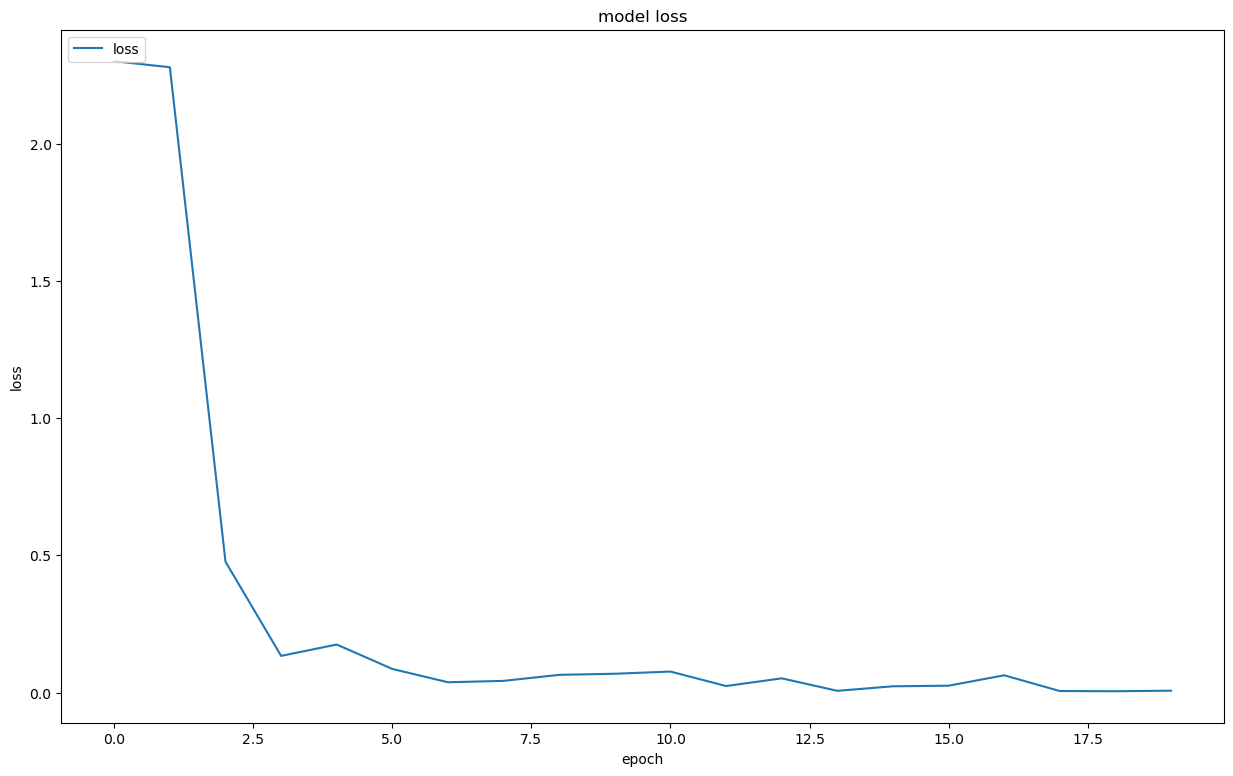

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(train_loss_list2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

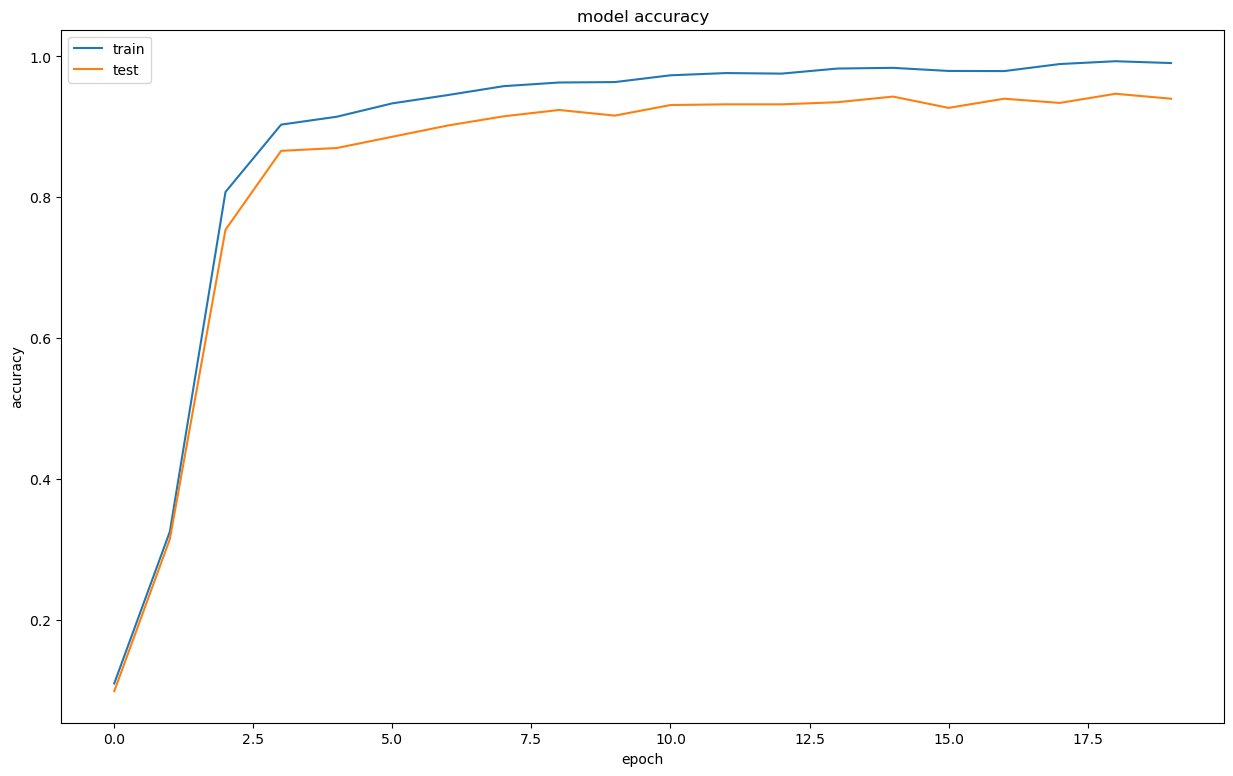

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show